In [1]:
import string
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import PorterStemmer, SnowballStemmer, LancasterStemmer
from sklearn.decomposition import TruncatedSVD, NMF
from gensim import corpora,models,matutils
from datetime import date, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
df=pd.read_csv("/Users/jaszeng/Desktop/Metis/NLP/Corona_NLP_train.csv",encoding='latin-1')
df1=pd.read_csv("/Users/jaszeng/Desktop/Metis/NLP/Corona_NLP_test.csv",encoding='latin-1')
df=df.append(df1).reset_index(drop=True)

In [3]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
df.iloc[7484,].OriginalTweet

'Our partners at @NetElixir are using their knowledge and tools to track changes in online shopping behavior as the situation surrounding the novel coronavirus develops. Stay up to date: https://t.co/hcael4jXeL'

In [5]:
df.info

<bound method DataFrame.info of        UserName  ScreenName             Location     TweetAt  \
0          3799       48751               London  16-03-2020   
1          3800       48752                   UK  16-03-2020   
2          3801       48753            Vagabonds  16-03-2020   
3          3802       48754                  NaN  16-03-2020   
4          3803       48755                  NaN  16-03-2020   
...         ...         ...                  ...         ...   
44950      3794       48746            Israel ??  16-03-2020   
44951      3795       48747       Farmington, NM  16-03-2020   
44952      3796       48748        Haverford, PA  16-03-2020   
44953      3797       48749                  NaN  16-03-2020   
44954      3798       48750  Arlington, Virginia  16-03-2020   

                                           OriginalTweet           Sentiment  
0      @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1      advice Talk to your neighbours fam

In [6]:
docs=df.OriginalTweet

In [7]:
stemmer = PorterStemmer()
analyzer = CountVectorizer(stop_words='english',max_df=0.7,min_df=5).build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [8]:
stem_vec = CountVectorizer(stop_words='english',max_df=0.7,min_df=5,analyzer=stemmed_words)

In [9]:
doc_term = stem_vec.fit_transform(docs)
doc_term.shape

(44955, 8300)

In [10]:
vocab_count=pd.Series(np.sum(doc_term.toarray(),axis=0).tolist(),index=stem_vec.vocabulary_.keys())
vocab_count.sort_values(ascending=False)[0:20]

tick            25839
internet        19685
share           13410
role            13006
queri            9614
upstream         9521
occur            8730
mcorkery5        8406
covid19k         7676
iphon            6394
zoonot           5837
void             5808
cdcgov           5561
wildlif          5248
correl           4715
ann              4020
askdrh           3964
did              3719
vow              3556
nhscovidhero     3531
dtype: int64

In [11]:
stemmer = PorterStemmer()
analyzer = TfidfVectorizer(stop_words='english',max_df=0.25,min_df=5).build_analyzer()
stem_vec_ti=TfidfVectorizer(stop_words='english',max_df=0.25,min_df=5,analyzer=stemmed_words)

In [12]:
doc_term_ti = stem_vec_ti.fit_transform(docs)

In [13]:
doc_term_ti.shape

(44955, 8296)

## Applying LSA, NMP to Doc-term Matrix

### 1. LSA

In [14]:
lsa=TruncatedSVD(5)
lsa.fit(doc_term_ti)

TruncatedSVD(n_components=5)

In [15]:
lsa.components_

array([[ 3.89158642e-03,  1.74144336e-02,  4.99666778e-04, ...,
         3.73397788e-04,  1.71151725e-04,  2.37392544e-04],
       [-2.13621202e-03, -1.07565428e-02, -3.81613882e-04, ...,
        -4.84099831e-04, -1.45623557e-04, -2.16349782e-04],
       [ 1.01758795e-03,  9.12937250e-03,  1.00294504e-04, ...,
        -6.17384409e-04,  4.47931488e-06, -1.69474016e-04],
       [-2.95922251e-03, -5.81112505e-03,  2.60634198e-04, ...,
         4.59970422e-04, -1.08044944e-04, -2.56443929e-04],
       [ 1.90768242e-03, -2.73281841e-03,  1.42987825e-05, ...,
        -4.36905586e-04, -1.11132365e-04,  6.28827208e-05]])

In [16]:
for i in range(5):
    topic = pd.Series(data=lsa.components_[i], 
                index=stem_vec_ti.get_feature_names()).sort_values(ascending=False)
    print('topic',(i+1),':\n',topic.head(10),"\n")

topic 1 :
 store          0.296144
groceri        0.269985
food           0.228361
shop           0.190878
supermarket    0.190150
peopl          0.189225
price          0.149398
covid_19       0.148612
amp            0.145600
onlin          0.137124
dtype: float64 

topic 2 :
 store            0.536715
groceri          0.515457
worker           0.143972
employe          0.079308
line             0.061226
work             0.060268
covid_19         0.058792
socialdistanc    0.051085
thank            0.043228
retail           0.041010
dtype: float64 

topic 3 :
 shop        0.533457
onlin       0.516502
consum      0.174673
retail      0.076031
busi        0.073219
price       0.070686
deliveri    0.070527
impact      0.065708
order       0.058136
behavior    0.055785
dtype: float64 

topic 4 :
 shop           0.348105
onlin          0.260797
supermarket    0.247804
food           0.226079
buy            0.197498
panic          0.196176
peopl          0.124230
need           0.080209
she

### 2. NMF

In [17]:
nmf=NMF(5)
tweet_topic=nmf.fit_transform(doc_term_ti)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [18]:
nmf.components_

array([[6.89210959e-03, 4.57014434e-02, 3.23366119e-03, ...,
        5.12790481e-03, 7.01287456e-04, 9.29683168e-04],
       [4.60527063e-03, 1.62578886e-02, 0.00000000e+00, ...,
        0.00000000e+00, 1.41501571e-04, 2.23952604e-05],
       [4.85196811e-03, 4.15130112e-02, 9.68212425e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.02726055e-02, 6.37928672e-02, 9.87730627e-04, ...,
        0.00000000e+00, 8.23611056e-04, 1.15680735e-03],
       [7.31401288e-03, 2.15655181e-02, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 6.08347008e-04]])

In [19]:
for i in range(5):
    topic = pd.Series(data=nmf.components_[i], 
                index=stem_vec_ti.get_feature_names()).sort_values(ascending=False)
    print('topic',(i+1),':\n',topic.head(10),"\n")

topic 1 :
 food           2.675195
supermarket    1.783751
buy            1.597473
panic          1.512739
peopl          1.383626
stock          1.190582
need           1.037507
suppli         0.623793
covid_19       0.618005
shelv          0.584714
dtype: float64 

topic 2 :
 store       2.604634
groceri     2.430517
worker      0.810926
covid_19    0.528996
work        0.488369
employe     0.428841
retail      0.371305
line        0.335477
thank       0.316158
go          0.305661
dtype: float64 

topic 3 :
 shop        2.533510
onlin       2.206922
deliveri    0.381634
home        0.295734
order       0.283919
stay        0.236099
safe        0.218679
time        0.191591
busi        0.187451
amazon      0.182671
dtype: float64 

topic 4 :
 price     2.213133
consum    1.166348
oil       0.876720
pandem    0.605488
market    0.527980
amp       0.523327
demand    0.447282
impact    0.435348
ga        0.390327
busi      0.361501
dtype: float64 

topic 5 :
 sanit      2.225939
hand   

## Define Topic

In [20]:
#based on LSA
#topics=['Grocery Shopping','Social Distance','Panic Food Buying','Online Food Delivery','Sanitary Product']
#based on NMF
topics=['Panic Food Buying','Social Distance','Online Food Delivery','Oil Price','Sanitary Product']

In [21]:
pred_topics = tweet_topic.argmax(axis=1)

# Use the index to map to the actual topic in `topics`
pred_topics = np.array(topics)[pred_topics]
df['Topic']=pred_topics

In [22]:
def get_week_time(date):
    return (date + timedelta(days=(6-date.weekday())))

In [23]:
df['TweetAt']=pd.to_datetime(df['TweetAt'])
df['Week']=df.TweetAt.apply(get_week_time)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Topic,Week
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Panic Food Buying,2020-03-22
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,Online Food Delivery,2020-03-22
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Online Food Delivery,2020-03-22
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,Panic Food Buying,2020-03-22
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Panic Food Buying,2020-03-22


In [24]:
topic_heat=df.groupby(['Topic','Week']).count().UserName.reset_index().rename(columns={'UserName':'Count'})

In [25]:
topic_heat

,Topic,Week,Count
0,Oil Price,2020-01-05,241
1,Oil Price,2020-02-09,449
2,Oil Price,2020-03-08,339
3,Oil Price,2020-03-15,311
4,Oil Price,2020-03-22,4807
...,...,...,...
78,Social Distance,2020-08-09,386
79,Social Distance,2020-09-06,219
80,Social Distance,2020-10-04,102
81,Social Distance,2020-11-08,128


In [26]:
topic_heat = topic_heat.pivot(index="Week", columns="Topic",values="Count")

In [27]:
topic_heat

Topic,Oil Price,Online Food Delivery,Panic Food Buying,Sanitary Product,Social Distance
Week,,,,,
2020-01-05,241.0,101.0,194.0,21.0,73.0
2020-02-09,449.0,145.0,233.0,31.0,100.0
2020-03-08,339.0,117.0,225.0,41.0,92.0
2020-03-15,311.0,339.0,908.0,108.0,700.0
2020-03-22,4807.0,1869.0,5656.0,1298.0,3647.0
2020-03-29,3000.0,862.0,1755.0,1296.0,1378.0
2020-04-05,383.0,151.0,408.0,69.0,167.0
2020-04-19,870.0,159.0,260.0,176.0,247.0
2020-05-03,4.0,NaN,1.0,NaN,1.0


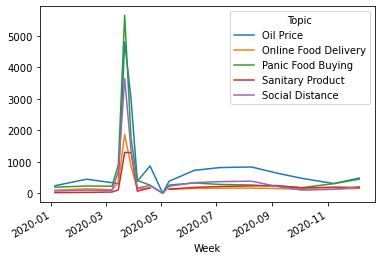

In [28]:
lines = topic_heat.plot.line()

## Sentimental Analysis using VADER

In [29]:
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        label="Positive"
    elif sentiment_dict['compound'] <= - 0.05 :
        label="Negative"
    else :
        label="Neutral"
    return label

In [30]:
df['Label']=df.OriginalTweet.apply(sentiment_scores)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Topic,Week,Label
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Panic Food Buying,2020-03-22,Neutral
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,Online Food Delivery,2020-03-22,Positive
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,Online Food Delivery,2020-03-22,Positive
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,Panic Food Buying,2020-03-22,Positive
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Panic Food Buying,2020-03-22,Positive


In [31]:
Pos_df=df[df['Label']=='Positive'][['Topic','Week','Label']]
Pos_df=Pos_df.groupby(['Topic','Week']).count().Label.reset_index().rename(columns={'Label':'Pos_Count'})
Neg_df=df[df['Label']=='Negative'][['Topic','Week','Label']]
Neg_df=Neg_df.groupby(['Topic','Week']).count().Label.reset_index().rename(columns={'Label':'Neg_Count'})

In [32]:
Pos_df

,Topic,Week,Pos_Count
0,Oil Price,2020-01-05,87
1,Oil Price,2020-02-09,150
2,Oil Price,2020-03-08,121
3,Oil Price,2020-03-15,125
4,Oil Price,2020-03-22,1900
...,...,...,...
77,Social Distance,2020-08-09,185
78,Social Distance,2020-09-06,111
79,Social Distance,2020-10-04,50
80,Social Distance,2020-11-08,66


In [33]:
Neg_df

,Topic,Week,Neg_Count
0,Oil Price,2020-01-05,104
1,Oil Price,2020-02-09,207
2,Oil Price,2020-03-08,165
3,Oil Price,2020-03-15,140
4,Oil Price,2020-03-22,2083
...,...,...,...
76,Social Distance,2020-08-09,138
77,Social Distance,2020-09-06,69
78,Social Distance,2020-10-04,30
79,Social Distance,2020-11-08,37


In [34]:
Senti_df=pd.merge(Pos_df, Neg_df, on=['Topic','Week'],how='outer')
Senti_df['Pos_Rate']=Senti_df['Pos_Count']/(Senti_df['Pos_Count']+Senti_df['Neg_Count'])
Senti_df=Senti_df[['Topic','Week','Pos_Rate']]

In [35]:
Senti_Analysis = Senti_df.pivot(index="Week", columns="Topic",values="Pos_Rate")

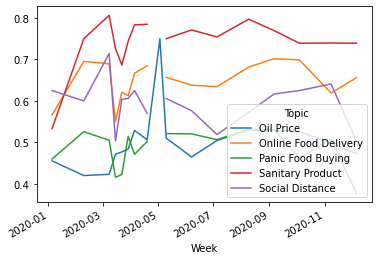

In [36]:
lines = Senti_Analysis.plot.line()

## Export dataframe to do visualization in Tableau

### For Plot 1

In [75]:
Tableau_df=df[['Location', 'TweetAt','Topic', 'Week', 'Label']]
#Tableau_df.to_csv("/Users/jaszeng/Desktop/Metis/NLP/Corona_NLP_Tableau.csv")

### For Plot 2

In [76]:
important_words=set()
for i in range(5):
    topic = pd.Series(data=nmf.components_[i], 
                index=stem_vec_ti.get_feature_names()).sort_values(ascending=False)
    important_words=important_words.union(set(topic.head(10).index))

In [86]:
term_importance=pd.DataFrame(nmf.components_,columns=stem_vec_ti.get_feature_names(),index=topics)
term_importance=term_importance[important_words]
term_importance

,order,groceri,shop,toilet,make,ga,suppli,soap,covid_19,peopl,...,stock,sanit,use,price,worker,store,safe,go,demand,hand
Panic Food Buying,0.063448,0.000000,0.00000,0.566310,0.196961,0.000000,0.623793,0.000000,0.618005,1.383626,...,1.190582,0.000000,0.080753,0.000000,0.158359,0.000000,0.074351,0.360797,0.415201,0.000000
Social Distance,0.065726,2.430517,0.00000,0.006031,0.110898,0.008104,0.000000,0.000000,0.528996,0.268353,...,0.000000,0.000000,0.019502,0.000000,0.810926,2.604634,0.112873,0.305661,0.000000,0.000000
Online Food Delivery,0.283919,0.000000,2.53351,0.000000,0.082078,0.000000,0.000000,0.000000,0.021209,0.120984,...,0.000000,0.000000,0.119951,0.000000,0.000000,0.000000,0.218679,0.091333,0.000000,0.000000
Oil Price,0.052868,0.000000,0.00000,0.000000,0.103154,0.390327,0.197641,0.000000,0.131111,0.006604,...,0.048591,0.000000,0.067650,2.213133,0.002681,0.000000,0.008765,0.038976,0.447282,0.000000
Sanitary Product,0.046067,0.000000,0.00000,0.425412,0.429871,0.000000,0.032037,0.359004,0.094164,0.046603,...,0.015058,2.225939,0.528349,0.000000,0.000000,0.000000,0.147742,0.000000,0.000000,2.198674


In [87]:
term_importance.to_csv("/Users/jaszeng/Desktop/Metis/NLP/Corona_NLP_important_term.csv")